In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from time import time

%matplotlib inline

In [2]:
file = pd.ExcelFile('dataPoints.xlsx')
df = file.parse('Foglio1')
df.head()

X = df[['x1', 'x2']].to_numpy()
y_true = df[['y']].to_numpy().reshape(1,-1)

X_train, X_test, y_train, y_test = train_test_split(X, y_true.reshape(-1,1), test_size=0.15, 
                                                    random_state=1869097)

y_train = y_train.reshape(1,-1)
y_test = y_test.reshape(1,-1)

In [15]:
def g_fun(T, sigma):
    num = np.exp(2*sigma*T) - 1
    den = np.exp(2*sigma*T) + 1
    return num / den

def convex_fun(X, v, W, b):
    
    # creating matrix X1 (X matrix plus array of ones)
    X1 = np.append(X, -1* np.ones((X.shape[0], 1)), axis=1)
    Wb = np.append(W, b, axis=1)

    return np.dot(v.T, g_fun(np.dot(Wb, np.transpose(X1)), sigma))

def convex_Grad(v, X_train, y_true, W, b):
    
    # merge W with b
    Wb = np.append(W, b, axis=1)
    
    # creating matrix X1 (X matrix plus array of ones)
    X1 = np.append(X_train, -1* np.ones((X_train.shape[0],1)), axis=1)

    # pick parameters from o
    v = v.reshape(N,1)
    omega = v.reshape(1,N)
        
    ### compute partial derivatives in a "pythonic" way:
    
    # for the sake of clearness, let's define some variables
    # (MATRIX1) dot product between Wb and X1
    T = np.dot(Wb, np.transpose(X1)) # NxX_train.shape[0] matrix
    
    # derivative of g()
    #g_der = 4 * sigma * np.exp(2 * sigma * T) / (np.exp(2 * sigma * T) + 1)**2

    dE_dv = 1 / X_train.shape[0] * np.dot(g_fun(T, sigma), \
                                          np.transpose(convex_fun(X_train, v, W, b) - y_true)) + 2 * rho * v

    return dE_dv.reshape(-1)

def convex_loss(v, X, y_true, W, b):
    y_pred = convex_fun(X, v, W, b)
    l = np.sum((y_pred - y_true)**2)/(2 * X.shape[0]) + rho * np.linalg.norm(v)**2
    #loss_history.append(l)
    return l


def non_convex_loss(omega, X, y_true, v):
    y_pred = non_convex_fun(X, omega, v)
    l = np.sum((y_pred - y_true)**2)/(2 * X.shape[0]) + rho * np.linalg.norm(omega)**2
    #loss_history.append(l)
    return l


def non_convex_fun(X, omega, v):  
    # creating matrix X1 (X matrix plus array of ones)
    X1 = np.append(X, -1* np.ones((X.shape[0], 1)), axis=1)

    # extract param vectors from omega
    W = omega[0:n*N].reshape(N, n)
    b = omega[n*N:].reshape(N, 1)
    
    # merge W with b
    Wb = np.append(W, b, axis=1)
    return np.dot(v.T, g_fun(np.dot(Wb, np.transpose(X1)), sigma))

def non_convex_Grad(omega, X_train, y_true, v):
    
    # creating matrix X1 (X matrix plus array of ones)
    X1 = np.append(X_train, -1* np.ones((X_train.shape[0],1)), axis=1)

    # pick parameters from omega one
    v = v.reshape(N,1)
    W = omega[0:n*N].reshape(N, n)
    b = omega[n*N:].reshape(N, 1)
    
    
    Wb = np.append(W,b, axis=1)
    
    ### compute partial derivatives in a "pythonic" way:
    
    # for the sake of clearness, let's define some variables
    # (MATRIX1) dot product between Wb and X1
    T = np.dot(Wb, np.transpose(X1)) # NxX_train.shape[0] matrix
    
    # derivative of g()
    g_der = 4 * sigma * np.exp(2 * sigma * T) / (np.exp(2 * sigma * T) + 1)**2

    #dE_dv = 1 / X_train.shape[0] * np.dot(g_fun(T, sigma), np.transpose(fun(X_train, omega) - y_true)) + 2 * rho * v
    dE_db = 1 / X_train.shape[0] * np.dot(-1 * v * g_der, \
                                          np.transpose(non_convex_fun(X_train, omega, v) - y_true)) + 2 * rho * b
    
    # dealing with dE_dW
    mat1 = v * g_der * X1[:,0]
    mat1 = np.dot(mat1, np.transpose(non_convex_fun(X_train, omega, v) - y_true))
    mat2 = v * g_der * X1[:,1]
    mat2 = np.dot(mat2, np.transpose(non_convex_fun(X_train, omega, v) - y_true))

    fusion = np.append(mat1, mat2, axis=1)
    dE_dW = 1 / X_train.shape[0] * fusion + 2 * rho * W

    omega_gradient = np.concatenate((dE_dW.reshape(N*n,1), dE_db))
    return omega_gradient.reshape(-1)

def MLP_fun(X, omega):
    
    # creating matrix X1 (X matrix plus array of ones)
    X1 = np.append(X, -1* np.ones((X.shape[0], 1)), axis=1)

    # extract param vectors from omega
    v = omega[0:N].reshape(N, 1)
    W = omega[N:3*N].reshape(N, n)
    b = omega[3*N:].reshape(N,1)
    
    # merge W with b
    Wb = np.append(W, b, axis=1)
    
    return np.dot(v.T, g_fun(np.dot(Wb, np.transpose(X1)), sigma))

def MLP_loss(omega, X, y_true):
    y_pred = MLP_fun(X, omega)
    l = np.sum((y_pred - y_true)**2)/(2 * X.shape[0]) + rho * np.linalg.norm(omega)**2
    #loss_history.append(l)
    return l

In [4]:
file = pd.ExcelFile('dataPoints.xlsx')
df = file.parse('Foglio1')
df.head()

X = df[['x1', 'x2']].to_numpy()
y_true = df[['y']].to_numpy().reshape(1,-1)

X_train, X_test, y_train, y_test = train_test_split(X, y_true.reshape(-1,1), test_size=0.15, 
                                                    random_state=1869097)

y_train = y_train.reshape(1,-1)
y_test = y_test.reshape(1,-1)

In [159]:
N = 30
n = np.shape(X)[1]
sigma = 1.8
rho = 0.00001


loss_history = []

W = np.random.randn(N,n)
b = np.random.randn(N,1)
v = np.random.randn(N,1)

# merge W with b
#Wb = np.append(W, b, axis=1)

t1 = time()
res = minimize(convex_loss, v, jac = convex_Grad, args=(X_train, y_train, W, b), method = "BFGS",
               options = {'gtol': 1e-8})
t1 = time()-t1
print(t1)

0.24480485916137695


In [160]:
print(res.message)
print('exec time:', t1)
print('fun:', res.fun)
print('success:',res.success)
print('nfev:', res.nfev)
print('nit:', res.nit)
print('njev:', res.njev)

Optimization terminated successfully.
exec time: 0.24480485916137695
fun: 0.04781073736081747
success: True
nfev: 264
nit: 261
njev: 264


In [161]:
np.linalg.norm(convex_Grad(res.x, X_train, y_train, W, b))

4.826880257086974e-09

In [129]:
# save the result 
v_star = res.x.copy().reshape(-1,1)

In [130]:
#create_omega
omega = np.concatenate((W.reshape(N*n, 1), b)).reshape(-1)
print(omega.shape)

(90,)


In [131]:
#print(non_convex_Grad(omega, X_train, y_train, v_star).shape)
#print(W.shape[0]*W.shape[1] + b.shape[0]) # check if it's the same.. OK! 

In [132]:
#non_convex_loss(omega, X, y_true, v_star)

In [133]:
t1 = time()
# adding a threshold on the gradient norm between 1e-2 and 1e-5
res = minimize(non_convex_loss, omega, jac = non_convex_Grad, args=(X_train, y_train, v_star), method = "BFGS",
               options={'gtol':1e-3})
t1 = time() - t1

In [134]:
print(res.message)
print('exec time:', t1)
print('fun:', res.fun)
print('success:',res.success)
print('nfev:', res.nfev)
print('nit:', res.nit)
print('njev:', res.njev)

Optimization terminated successfully.
exec time: 0.41059422492980957
fun: 0.001442896503052715
success: True
nfev: 237
nit: 233
njev: 237


In [135]:
# losses
v_star
W_and_b_star = res.x

W_star = res.x[0:n*N].reshape(N, n)
b_star = res.x[n*N:].reshape(N,1)


print('---- Convex loss ----')
print('train:', convex_loss(v_star, X_train, y_train, W_star, b_star))
print('test:', convex_loss(v_star, X_test, y_test, W_star, b_star), '\n')


print('---- Non Convex loss ----')
print('train:', non_convex_loss(W_and_b_star, X_train, y_train, v_star))
print('test:', non_convex_loss(W_and_b_star, X_test, y_test, v_star), '\n')



omega_star = np.concatenate((v_star.reshape(-1,1), W_star.reshape(N*n,1), b_star)).reshape(-1)

print('---- Overall loss ----')
print('train:', MLP_loss(omega_star, X_train, y_train))
print('test:', MLP_loss(omega_star, X_test, y_test))

---- Convex loss ----
train: 0.03921374114009928
test: 0.07173214038830796 

---- Non Convex loss ----
train: 0.001442896503052715
test: 0.0014422188070209903 

---- Overall loss ----
train: 0.0039289723900713105
test: 0.003928294694039586


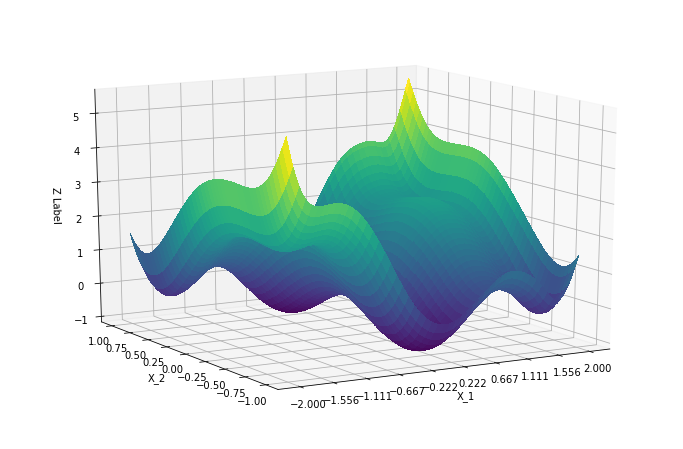

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

X_1 = np.linspace(-2,2,100)
X_2 = np.linspace(-1,1,100)
X_1, X_2 = np.meshgrid(X_1, X_2)
zs = np.array([MLP_fun(np.array([x,y]).reshape(1,2), omega_star) for x,y in zip(np.ravel(X_1), np.ravel(X_2))])
Z = zs.reshape(X_1.shape)
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
ax.plot_surface(X_1, X_2, Z ,linewidth=0,cmap=cm.viridis, antialiased=False)
ax.set_xticks((np.linspace(-2,2,10)))
ax.view_init(elev=15, azim=240)
ax.set_xlabel('X_1')
ax.set_ylabel('X_2')
ax.set_zlabel('Z Label')
plt.savefig('graph_question_1_1.png',dpi=600)
plt.show()

# Hyperloop

In [21]:
def stopping_creteria(X_train, y_train, v, W, b, threshold=[1e-8, 1e-3]):
    
    eps1 = threshold[0]
    eps2 = threshold[1]
    
    conv_gradient = convex_Grad(v, X_train, y_train, W, b)
    
    W_and_b = np.concatenate((W.reshape(N*n,1), b)).reshape(-1)
    non_conv_gradient = non_convex_Grad(W_and_b, X_train, y_train, v)
    

    conv_module = np.linalg.norm(conv_gradient)
    non_conv_module = np.linalg.norm(non_conv_gradient)
    
    #print(conv_module, non_conv_module)
    if (conv_module < eps1) and (non_conv_module < eps2):
        return True
    else:
        return False

In [23]:
#stopping_creteria(X_train, y_train, res.x, W, b)

In [24]:
#while(stopping_creteria(X_train, y_train, v, W, b)):
    # minimize the convex func
    # update v
    
    # minimize the non convex func
    # update W and b
#    pass

In [25]:
N = 30
n = np.shape(X)[1]
sigma = 1.8
rho = 0.00001


history = {}

W0 = np.random.randn(N,n)
b0 = np.random.randn(N,1)
v0 = np.random.randn(N,1)

cnt = 0

omega = np.concatenate((v0, W0.reshape(N*n,1), b0))

history[0] = {'Error': MLP_loss(omega, X_train, y_train),
              'v': v0.copy(),
              'W': W0.copy(),
              'b': b0.copy()
             }


while not stopping_creteria(X_train, y_train,
                            history[cnt]['v'], history[cnt]['W'], history[cnt]['b']):
    print('{}, ' .format(cnt), end='')
    
    v = history[cnt]['v'].copy()
    W = history[cnt]['W'].copy()
    b = history[cnt]['b'].copy()
    
    res = minimize(convex_loss, v, jac = convex_Grad, args=(X_train, y_train, W, b), method = "BFGS",
               options = {'gtol': 1e-8})
    
    v_star = res.x.copy()
    omega = res.x.copy() # for the final evaluation of MLP_loss
    conv_gradient = res.jac.copy()
    conv_module = np.linalg.norm(conv_gradient)
    print("conv_mod = ", conv_module, res.success)
    
    W_and_b = np.concatenate((W.reshape(N*n,1), b))
    
    res = minimize(non_convex_loss, W_and_b, jac=non_convex_Grad, args=(X_train, y_train, v_star), 
                   method = "BFGS", options={'gtol':1e-3})
    print(res.success)
    
    W_star = res.x[0:n*N].reshape(N,n)
    b_star = res.x[n*N:].reshape(N,1)
    
    omega = np.append(omega, res.x) 
    
    cnt += 1
    history[cnt] = {'Error': MLP_loss(omega, X_train, y_train),
              'v': v_star.copy(),
              'W': W_star.copy(),
              'b': b_star.copy()
             }
    
    

0, conv_mod =  9.434486677497896e-09 True
True
1, conv_mod =  1.609979291043209e-08 True
True
2, conv_mod =  1.2891945887563318e-08 True
True
3, conv_mod =  9.839395214000877e-09 True
True
4, conv_mod =  8.89746474670303e-09 True
True
5, conv_mod =  1.9354268325809905e-08 True
True
6, conv_mod =  1.745969445695358e-08 True
True
7, conv_mod =  1.9955039617477087e-08 True
True
8, conv_mod =  1.4711214374715354e-08 True
True
9, conv_mod =  1.4711214374715354e-08 True
True
10, conv_mod =  1.4711214374715354e-08 True
True
11, conv_mod =  1.4711214374715354e-08 True
True
12, conv_mod =  1.4711214374715354e-08 True
True
13, conv_mod =  1.4711214374715354e-08 True
True
14, conv_mod =  1.4711214374715354e-08 True
True
15, conv_mod =  1.4711214374715354e-08 True
True
16, conv_mod =  1.4711214374715354e-08 True
True
17, conv_mod =  1.4711214374715354e-08 True
True
18, conv_mod =  1.4711214374715354e-08 True
True
19, conv_mod =  1.4711214374715354e-08 True
True
20, conv_mod =  1.4711214374715354e-

195, conv_mod =  1.4711214374715354e-08 True
True
196, conv_mod =  1.4711214374715354e-08 True
True
197, conv_mod =  1.4711214374715354e-08 True
True
198, conv_mod =  1.4711214374715354e-08 True
True
199, conv_mod =  1.4711214374715354e-08 True
True
200, conv_mod =  1.4711214374715354e-08 True
True
201, conv_mod =  1.4711214374715354e-08 True
True
202, conv_mod =  1.4711214374715354e-08 True
True
203, conv_mod =  1.4711214374715354e-08 True
True
204, conv_mod =  1.4711214374715354e-08 True
True
205, conv_mod =  1.4711214374715354e-08 True
True
206, conv_mod =  1.4711214374715354e-08 True
True
207, conv_mod =  1.4711214374715354e-08 True
True
208, conv_mod =  1.4711214374715354e-08 True
True
209, conv_mod =  1.4711214374715354e-08 True
True
210, conv_mod =  1.4711214374715354e-08 True
True
211, conv_mod =  1.4711214374715354e-08 True
True
212, conv_mod =  1.4711214374715354e-08 True
True
213, conv_mod =  1.4711214374715354e-08 True
True
214, conv_mod =  1.4711214374715354e-08 True
True


369, conv_mod =  1.4711214374715354e-08 True
True
370, conv_mod =  1.4711214374715354e-08 True
True
371, conv_mod =  1.4711214374715354e-08 True
True
372, conv_mod =  1.4711214374715354e-08 True
True
373, conv_mod =  1.4711214374715354e-08 True
True
374, conv_mod =  1.4711214374715354e-08 True
True
375, conv_mod =  1.4711214374715354e-08 True
True
376, conv_mod =  1.4711214374715354e-08 True
True
377, conv_mod =  1.4711214374715354e-08 True
True
378, conv_mod =  1.4711214374715354e-08 True
True
379, conv_mod =  1.4711214374715354e-08 True
True
380, conv_mod =  1.4711214374715354e-08 True
True
381, conv_mod =  1.4711214374715354e-08 True
True
382, conv_mod =  1.4711214374715354e-08 True
True
383, conv_mod =  1.4711214374715354e-08 True
True
384, conv_mod =  1.4711214374715354e-08 True
True
385, conv_mod =  1.4711214374715354e-08 True
True
386, conv_mod =  1.4711214374715354e-08 True
True
387, conv_mod =  1.4711214374715354e-08 True
True
388, conv_mod =  1.4711214374715354e-08 True
True


True
534, conv_mod =  1.4711214374715354e-08 True
True
535, conv_mod =  1.4711214374715354e-08 True
True
536, conv_mod =  1.4711214374715354e-08 True
True
537, conv_mod =  1.4711214374715354e-08 True
True
538, conv_mod =  1.4711214374715354e-08 True
True
539, conv_mod =  1.4711214374715354e-08 True
True
540, conv_mod =  1.4711214374715354e-08 True
True
541, conv_mod =  1.4711214374715354e-08 True
True
542, conv_mod =  1.4711214374715354e-08 True
True
543, conv_mod =  1.4711214374715354e-08 True
True
544, conv_mod =  1.4711214374715354e-08 True
True
545, conv_mod =  1.4711214374715354e-08 True
True
546, conv_mod =  1.4711214374715354e-08 True
True
547, conv_mod =  1.4711214374715354e-08 True
True
548, conv_mod =  1.4711214374715354e-08 True
True
549, conv_mod =  1.4711214374715354e-08 True
True
550, conv_mod =  1.4711214374715354e-08 True
True
551, conv_mod =  1.4711214374715354e-08 True
True
552, conv_mod =  1.4711214374715354e-08 True
True
553, conv_mod =  1.4711214374715354e-08 True


True
721, conv_mod =  1.4711214374715354e-08 True
True
722, conv_mod =  1.4711214374715354e-08 True
True
723, conv_mod =  1.4711214374715354e-08 True
True
724, conv_mod =  1.4711214374715354e-08 True
True
725, conv_mod =  1.4711214374715354e-08 True
True
726, conv_mod =  1.4711214374715354e-08 True
True
727, conv_mod =  1.4711214374715354e-08 True
True
728, conv_mod =  1.4711214374715354e-08 True
True
729, conv_mod =  1.4711214374715354e-08 True
True
730, conv_mod =  1.4711214374715354e-08 True
True
731, conv_mod =  1.4711214374715354e-08 True
True
732, conv_mod =  1.4711214374715354e-08 True
True
733, conv_mod =  1.4711214374715354e-08 True
True
734, conv_mod =  1.4711214374715354e-08 True
True
735, conv_mod =  1.4711214374715354e-08 True
True
736, conv_mod =  1.4711214374715354e-08 True
True
737, conv_mod =  1.4711214374715354e-08 True
True
738, conv_mod =  1.4711214374715354e-08 True
True
739, conv_mod =  1.4711214374715354e-08 True
True
740, conv_mod =  1.4711214374715354e-08 True


903, conv_mod =  1.4711214374715354e-08 True
True
904, conv_mod =  1.4711214374715354e-08 True
True
905, conv_mod =  1.4711214374715354e-08 True
True
906, conv_mod =  1.4711214374715354e-08 True
True
907, conv_mod =  1.4711214374715354e-08 True
True
908, conv_mod =  1.4711214374715354e-08 True
True
909, conv_mod =  1.4711214374715354e-08 True
True
910, conv_mod =  1.4711214374715354e-08 True
True
911, conv_mod =  1.4711214374715354e-08 True
True
912, conv_mod =  1.4711214374715354e-08 True
True
913, conv_mod =  1.4711214374715354e-08 True
True
914, conv_mod =  1.4711214374715354e-08 True
True
915, conv_mod =  1.4711214374715354e-08 True
True
916, conv_mod =  1.4711214374715354e-08 True
True
917, conv_mod =  1.4711214374715354e-08 True
True
918, conv_mod =  1.4711214374715354e-08 True
True
919, conv_mod =  1.4711214374715354e-08 True
True
920, conv_mod =  1.4711214374715354e-08 True
True
921, conv_mod =  1.4711214374715354e-08 True
True
922, conv_mod =  1.4711214374715354e-08 True
True


True
1085, conv_mod =  1.4711214374715354e-08 True
True
1086, conv_mod =  1.4711214374715354e-08 True
True
1087, conv_mod =  1.4711214374715354e-08 True
True
1088, conv_mod =  1.4711214374715354e-08 True
True
1089, conv_mod =  1.4711214374715354e-08 True
True
1090, conv_mod =  1.4711214374715354e-08 True
True
1091, conv_mod =  1.4711214374715354e-08 True
True
1092, conv_mod =  1.4711214374715354e-08 True
True
1093, conv_mod =  1.4711214374715354e-08 True
True
1094, conv_mod =  1.4711214374715354e-08 True
True
1095, conv_mod =  1.4711214374715354e-08 True
True
1096, conv_mod =  1.4711214374715354e-08 True
True
1097, conv_mod =  1.4711214374715354e-08 True
True
1098, conv_mod =  1.4711214374715354e-08 True
True
1099, conv_mod =  1.4711214374715354e-08 True
True
1100, conv_mod =  1.4711214374715354e-08 True
True
1101, conv_mod =  1.4711214374715354e-08 True
True
1102, conv_mod =  1.4711214374715354e-08 True
True
1103, conv_mod =  1.4711214374715354e-08 True
True
1104, conv_mod =  1.471121

True
1267, conv_mod =  1.4711214374715354e-08 True
True
1268, conv_mod =  1.4711214374715354e-08 True
True
1269, conv_mod =  1.4711214374715354e-08 True
True
1270, conv_mod =  1.4711214374715354e-08 True
True
1271, conv_mod =  1.4711214374715354e-08 True
True
1272, conv_mod =  1.4711214374715354e-08 True
True
1273, conv_mod =  1.4711214374715354e-08 True
True
1274, conv_mod =  1.4711214374715354e-08 True
True
1275, conv_mod =  1.4711214374715354e-08 True
True
1276, conv_mod =  1.4711214374715354e-08 True
True
1277, conv_mod =  1.4711214374715354e-08 True
True
1278, conv_mod =  1.4711214374715354e-08 True
True
1279, conv_mod =  1.4711214374715354e-08 True
True
1280, conv_mod =  1.4711214374715354e-08 True
True
1281, conv_mod =  1.4711214374715354e-08 True
True
1282, conv_mod =  1.4711214374715354e-08 True
True
1283, conv_mod =  1.4711214374715354e-08 True
True
1284, conv_mod =  1.4711214374715354e-08 True
True
1285, conv_mod =  1.4711214374715354e-08 True
True
1286, conv_mod =  1.471121

True
1431, conv_mod =  1.4711214374715354e-08 True
True
1432, conv_mod =  1.4711214374715354e-08 True
True
1433, conv_mod =  1.4711214374715354e-08 True
True
1434, conv_mod =  1.4711214374715354e-08 True
True
1435, conv_mod =  1.4711214374715354e-08 True
True
1436, conv_mod =  1.4711214374715354e-08 True
True
1437, conv_mod =  1.4711214374715354e-08 True
True
1438, conv_mod =  1.4711214374715354e-08 True
True
1439, conv_mod =  1.4711214374715354e-08 True
True
1440, conv_mod =  1.4711214374715354e-08 True
True
1441, conv_mod =  1.4711214374715354e-08 True
True
1442, conv_mod =  1.4711214374715354e-08 True
True
1443, conv_mod =  1.4711214374715354e-08 True
True
1444, conv_mod =  1.4711214374715354e-08 True
True
1445, conv_mod =  1.4711214374715354e-08 True
True
1446, conv_mod =  1.4711214374715354e-08 True
True
1447, conv_mod =  1.4711214374715354e-08 True
True
1448, conv_mod =  1.4711214374715354e-08 True
True
1449, conv_mod =  1.4711214374715354e-08 True
True
1450, conv_mod =  1.471121

True
1605, conv_mod =  1.4711214374715354e-08 True
True
1606, conv_mod =  1.4711214374715354e-08 True
True
1607, conv_mod =  1.4711214374715354e-08 True
True
1608, conv_mod =  1.4711214374715354e-08 True
True
1609, conv_mod =  1.4711214374715354e-08 True
True
1610, conv_mod =  1.4711214374715354e-08 True
True
1611, conv_mod =  1.4711214374715354e-08 True
True
1612, conv_mod =  1.4711214374715354e-08 True
True
1613, conv_mod =  1.4711214374715354e-08 True
True
1614, conv_mod =  1.4711214374715354e-08 True
True
1615, conv_mod =  1.4711214374715354e-08 True
True
1616, conv_mod =  1.4711214374715354e-08 True
True
1617, conv_mod =  1.4711214374715354e-08 True
True
1618, conv_mod =  1.4711214374715354e-08 True
True
1619, conv_mod =  1.4711214374715354e-08 True
True
1620, conv_mod =  1.4711214374715354e-08 True
True
1621, conv_mod =  1.4711214374715354e-08 True
True
1622, conv_mod =  1.4711214374715354e-08 True
True
1623, conv_mod =  1.4711214374715354e-08 True
True
1624, conv_mod =  1.471121

1774, conv_mod =  1.4711214374715354e-08 True
True
1775, conv_mod =  1.4711214374715354e-08 True
True
1776, conv_mod =  1.4711214374715354e-08 True
True
1777, conv_mod =  1.4711214374715354e-08 True
True
1778, conv_mod =  1.4711214374715354e-08 True
True
1779, conv_mod =  1.4711214374715354e-08 True
True
1780, conv_mod =  1.4711214374715354e-08 True
True
1781, conv_mod =  1.4711214374715354e-08 True
True
1782, conv_mod =  1.4711214374715354e-08 True
True
1783, conv_mod =  1.4711214374715354e-08 True
True
1784, conv_mod =  1.4711214374715354e-08 True
True
1785, conv_mod =  1.4711214374715354e-08 True
True
1786, conv_mod =  1.4711214374715354e-08 True
True
1787, conv_mod =  1.4711214374715354e-08 True
True
1788, conv_mod =  1.4711214374715354e-08 True
True
1789, conv_mod =  1.4711214374715354e-08 True
True
1790, conv_mod =  1.4711214374715354e-08 True
True
1791, conv_mod =  1.4711214374715354e-08 True
True
1792, conv_mod =  1.4711214374715354e-08 True
True
1793, conv_mod =  1.47112143747

True
1941, conv_mod =  1.4711214374715354e-08 True
True
1942, conv_mod =  1.4711214374715354e-08 True
True
1943, conv_mod =  1.4711214374715354e-08 True
True
1944, conv_mod =  1.4711214374715354e-08 True
True
1945, conv_mod =  1.4711214374715354e-08 True
True
1946, conv_mod =  1.4711214374715354e-08 True
True
1947, conv_mod =  1.4711214374715354e-08 True
True
1948, conv_mod =  1.4711214374715354e-08 True
True
1949, conv_mod =  1.4711214374715354e-08 True
True
1950, conv_mod =  1.4711214374715354e-08 True
True
1951, conv_mod =  1.4711214374715354e-08 True
True
1952, conv_mod =  1.4711214374715354e-08 True
True
1953, conv_mod =  1.4711214374715354e-08 True
True
1954, conv_mod =  1.4711214374715354e-08 True
True
1955, conv_mod =  1.4711214374715354e-08 True
True
1956, conv_mod =  1.4711214374715354e-08 True
True
1957, conv_mod =  1.4711214374715354e-08 True
True
1958, conv_mod =  1.4711214374715354e-08 True
True
1959, conv_mod =  1.4711214374715354e-08 True
True
1960, conv_mod =  1.471121

True
2134, conv_mod =  1.4711214374715354e-08 True
True
2135, conv_mod =  1.4711214374715354e-08 True
True
2136, conv_mod =  1.4711214374715354e-08 True
True
2137, conv_mod =  1.4711214374715354e-08 True
True
2138, conv_mod =  1.4711214374715354e-08 True
True
2139, conv_mod =  1.4711214374715354e-08 True
True
2140, conv_mod =  1.4711214374715354e-08 True
True
2141, conv_mod =  1.4711214374715354e-08 True
True
2142, conv_mod =  1.4711214374715354e-08 True
True
2143, conv_mod =  1.4711214374715354e-08 True
True
2144, conv_mod =  1.4711214374715354e-08 True
True
2145, conv_mod =  1.4711214374715354e-08 True
True
2146, conv_mod =  1.4711214374715354e-08 True
True
2147, conv_mod =  1.4711214374715354e-08 True
True
2148, conv_mod =  1.4711214374715354e-08 True
True
2149, conv_mod =  1.4711214374715354e-08 True
True
2150, conv_mod =  1.4711214374715354e-08 True
True
2151, conv_mod =  1.4711214374715354e-08 True
True
2152, conv_mod =  1.4711214374715354e-08 True
True
2153, conv_mod =  1.471121

2315, conv_mod =  1.4711214374715354e-08 True
True
2316, conv_mod =  1.4711214374715354e-08 True
True
2317, conv_mod =  1.4711214374715354e-08 True
True
2318, conv_mod =  1.4711214374715354e-08 True
True
2319, conv_mod =  1.4711214374715354e-08 True
True
2320, conv_mod =  1.4711214374715354e-08 True
True
2321, conv_mod =  1.4711214374715354e-08 True
True
2322, conv_mod =  1.4711214374715354e-08 True
True
2323, conv_mod =  1.4711214374715354e-08 True
True
2324, conv_mod =  1.4711214374715354e-08 True
True
2325, conv_mod =  1.4711214374715354e-08 True
True
2326, conv_mod =  1.4711214374715354e-08 True
True
2327, conv_mod =  1.4711214374715354e-08 True
True
2328, conv_mod =  1.4711214374715354e-08 True
True
2329, conv_mod =  1.4711214374715354e-08 True
True
2330, conv_mod =  1.4711214374715354e-08 True
True
2331, conv_mod =  1.4711214374715354e-08 True
True
2332, conv_mod =  1.4711214374715354e-08 True
True
2333, conv_mod =  1.4711214374715354e-08 True
True
2334, conv_mod =  1.47112143747

2488, conv_mod =  1.4711214374715354e-08 True
True
2489, conv_mod =  1.4711214374715354e-08 True
True
2490, conv_mod =  1.4711214374715354e-08 True
True
2491, conv_mod =  1.4711214374715354e-08 True
True
2492, conv_mod =  1.4711214374715354e-08 True
True
2493, conv_mod =  1.4711214374715354e-08 True
True
2494, conv_mod =  1.4711214374715354e-08 True
True
2495, conv_mod =  1.4711214374715354e-08 True
True
2496, conv_mod =  1.4711214374715354e-08 True
True
2497, conv_mod =  1.4711214374715354e-08 True
True
2498, conv_mod =  1.4711214374715354e-08 True
True
2499, conv_mod =  1.4711214374715354e-08 True
True
2500, conv_mod =  1.4711214374715354e-08 True
True
2501, conv_mod =  1.4711214374715354e-08 True
True
2502, conv_mod =  1.4711214374715354e-08 True
True
2503, conv_mod =  1.4711214374715354e-08 True
True
2504, conv_mod =  1.4711214374715354e-08 True
True
2505, conv_mod =  1.4711214374715354e-08 True
True
2506, conv_mod =  1.4711214374715354e-08 True
True
2507, conv_mod =  1.47112143747

True
2665, conv_mod =  1.4711214374715354e-08 True
True
2666, conv_mod =  1.4711214374715354e-08 True
True
2667, conv_mod =  1.4711214374715354e-08 True
True
2668, conv_mod =  1.4711214374715354e-08 True
True
2669, conv_mod =  1.4711214374715354e-08 True
True
2670, conv_mod =  1.4711214374715354e-08 True
True
2671, conv_mod =  1.4711214374715354e-08 True
True
2672, conv_mod =  1.4711214374715354e-08 True
True
2673, conv_mod =  1.4711214374715354e-08 True
True
2674, conv_mod =  1.4711214374715354e-08 True
True
2675, conv_mod =  1.4711214374715354e-08 True
True
2676, conv_mod =  1.4711214374715354e-08 True
True
2677, conv_mod =  1.4711214374715354e-08 True
True
2678, conv_mod =  1.4711214374715354e-08 True
True
2679, conv_mod =  1.4711214374715354e-08 True
True
2680, conv_mod =  1.4711214374715354e-08 True
True
2681, conv_mod =  1.4711214374715354e-08 True
True
2682, conv_mod =  1.4711214374715354e-08 True
True
2683, conv_mod =  1.4711214374715354e-08 True
True
2684, conv_mod =  1.471121

2855, conv_mod =  1.4711214374715354e-08 True
True
2856, conv_mod =  1.4711214374715354e-08 True
True
2857, conv_mod =  1.4711214374715354e-08 True
True
2858, conv_mod =  1.4711214374715354e-08 True
True
2859, conv_mod =  1.4711214374715354e-08 True
True
2860, conv_mod =  1.4711214374715354e-08 True
True
2861, conv_mod =  1.4711214374715354e-08 True
True
2862, conv_mod =  1.4711214374715354e-08 True
True
2863, conv_mod =  1.4711214374715354e-08 True
True
2864, conv_mod =  1.4711214374715354e-08 True
True
2865, conv_mod =  1.4711214374715354e-08 True
True
2866, conv_mod =  1.4711214374715354e-08 True
True
2867, conv_mod =  1.4711214374715354e-08 True
True
2868, conv_mod =  1.4711214374715354e-08 True
True
2869, conv_mod =  1.4711214374715354e-08 True
True
2870, conv_mod =  1.4711214374715354e-08 True
True
2871, conv_mod =  1.4711214374715354e-08 True
True
2872, conv_mod =  1.4711214374715354e-08 True
True
2873, conv_mod =  1.4711214374715354e-08 True
True
2874, conv_mod =  1.47112143747

3035, conv_mod =  1.4711214374715354e-08 True
True
3036, conv_mod =  1.4711214374715354e-08 True
True
3037, conv_mod =  1.4711214374715354e-08 True
True
3038, conv_mod =  1.4711214374715354e-08 True
True
3039, conv_mod =  1.4711214374715354e-08 True
True
3040, conv_mod =  1.4711214374715354e-08 True
True
3041, conv_mod =  1.4711214374715354e-08 True
True
3042, conv_mod =  1.4711214374715354e-08 True
True
3043, conv_mod =  1.4711214374715354e-08 True
True
3044, conv_mod =  1.4711214374715354e-08 True
True
3045, conv_mod =  1.4711214374715354e-08 True
True
3046, conv_mod =  1.4711214374715354e-08 True
True
3047, conv_mod =  1.4711214374715354e-08 True
True
3048, conv_mod =  1.4711214374715354e-08 True
True
3049, conv_mod =  1.4711214374715354e-08 True
True
3050, conv_mod =  1.4711214374715354e-08 True
True
3051, conv_mod =  1.4711214374715354e-08 True
True
3052, conv_mod =  1.4711214374715354e-08 True
True
3053, conv_mod =  1.4711214374715354e-08 True
True
3054, conv_mod =  1.47112143747

3196, conv_mod =  1.4711214374715354e-08 True
True
3197, conv_mod =  1.4711214374715354e-08 True
True
3198, conv_mod =  1.4711214374715354e-08 True
True
3199, conv_mod =  1.4711214374715354e-08 True
True
3200, conv_mod =  1.4711214374715354e-08 True
True
3201, conv_mod =  1.4711214374715354e-08 True
True
3202, conv_mod =  1.4711214374715354e-08 True
True
3203, conv_mod =  1.4711214374715354e-08 True
True
3204, conv_mod =  1.4711214374715354e-08 True
True
3205, conv_mod =  1.4711214374715354e-08 True
True
3206, conv_mod =  1.4711214374715354e-08 True
True
3207, conv_mod =  1.4711214374715354e-08 True
True
3208, conv_mod =  1.4711214374715354e-08 True
True
3209, conv_mod =  1.4711214374715354e-08 True
True
3210, conv_mod =  1.4711214374715354e-08 True
True
3211, conv_mod =  1.4711214374715354e-08 True
True
3212, conv_mod =  1.4711214374715354e-08 True
True
3213, conv_mod =  1.4711214374715354e-08 True
True
3214, conv_mod =  1.4711214374715354e-08 True
True
3215, conv_mod =  1.47112143747

True
3378, conv_mod =  1.4711214374715354e-08 True
True
3379, conv_mod =  1.4711214374715354e-08 True
True
3380, conv_mod =  1.4711214374715354e-08 True
True
3381, conv_mod =  1.4711214374715354e-08 True
True
3382, conv_mod =  1.4711214374715354e-08 True
True
3383, conv_mod =  1.4711214374715354e-08 True
True
3384, conv_mod =  1.4711214374715354e-08 True
True
3385, conv_mod =  1.4711214374715354e-08 True
True
3386, conv_mod =  1.4711214374715354e-08 True
True
3387, conv_mod =  1.4711214374715354e-08 True
True
3388, conv_mod =  1.4711214374715354e-08 True
True
3389, conv_mod =  1.4711214374715354e-08 True
True
3390, conv_mod =  1.4711214374715354e-08 True
True
3391, conv_mod =  1.4711214374715354e-08 True
True
3392, conv_mod =  1.4711214374715354e-08 True
True
3393, conv_mod =  1.4711214374715354e-08 True
True
3394, conv_mod =  1.4711214374715354e-08 True
True
3395, conv_mod =  1.4711214374715354e-08 True
True
3396, conv_mod =  1.4711214374715354e-08 True
True
3397, conv_mod =  1.471121

True
3563, conv_mod =  1.4711214374715354e-08 True
True
3564, conv_mod =  1.4711214374715354e-08 True
True
3565, conv_mod =  1.4711214374715354e-08 True
True
3566, conv_mod =  1.4711214374715354e-08 True
True
3567, conv_mod =  1.4711214374715354e-08 True
True
3568, conv_mod =  1.4711214374715354e-08 True
True
3569, conv_mod =  1.4711214374715354e-08 True
True
3570, conv_mod =  1.4711214374715354e-08 True
True
3571, conv_mod =  1.4711214374715354e-08 True
True
3572, conv_mod =  1.4711214374715354e-08 True
True
3573, conv_mod =  1.4711214374715354e-08 True
True
3574, conv_mod =  1.4711214374715354e-08 True
True
3575, conv_mod =  1.4711214374715354e-08 True
True
3576, conv_mod =  1.4711214374715354e-08 True
True
3577, conv_mod =  1.4711214374715354e-08 True
True
3578, conv_mod =  1.4711214374715354e-08 True
True
3579, conv_mod =  1.4711214374715354e-08 True
True
3580, conv_mod =  1.4711214374715354e-08 True
True
3581, conv_mod =  1.4711214374715354e-08 True
True
3582, conv_mod =  1.471121

3731, conv_mod =  1.4711214374715354e-08 True
True
3732, conv_mod =  1.4711214374715354e-08 True
True
3733, conv_mod =  1.4711214374715354e-08 True
True
3734, conv_mod =  1.4711214374715354e-08 True
True
3735, conv_mod =  1.4711214374715354e-08 True
True
3736, conv_mod =  1.4711214374715354e-08 True
True
3737, conv_mod =  1.4711214374715354e-08 True
True
3738, conv_mod =  1.4711214374715354e-08 True
True
3739, conv_mod =  1.4711214374715354e-08 True
True
3740, conv_mod =  1.4711214374715354e-08 True
True
3741, conv_mod =  1.4711214374715354e-08 True
True
3742, conv_mod =  1.4711214374715354e-08 True
True
3743, conv_mod =  1.4711214374715354e-08 True
True
3744, conv_mod =  1.4711214374715354e-08 True
True
3745, conv_mod =  1.4711214374715354e-08 True
True
3746, conv_mod =  1.4711214374715354e-08 True
True
3747, conv_mod =  1.4711214374715354e-08 True
True
3748, conv_mod =  1.4711214374715354e-08 True
True
3749, conv_mod =  1.4711214374715354e-08 True
True
3750, conv_mod =  1.47112143747

True
3895, conv_mod =  1.4711214374715354e-08 True
True
3896, conv_mod =  1.4711214374715354e-08 True
True
3897, conv_mod =  1.4711214374715354e-08 True
True
3898, conv_mod =  1.4711214374715354e-08 True
True
3899, conv_mod =  1.4711214374715354e-08 True
True
3900, conv_mod =  1.4711214374715354e-08 True
True
3901, conv_mod =  1.4711214374715354e-08 True
True
3902, conv_mod =  1.4711214374715354e-08 True
True
3903, conv_mod =  1.4711214374715354e-08 True
True
3904, conv_mod =  1.4711214374715354e-08 True
True
3905, conv_mod =  1.4711214374715354e-08 True
True
3906, conv_mod =  1.4711214374715354e-08 True
True
3907, conv_mod =  1.4711214374715354e-08 True
True
3908, conv_mod =  1.4711214374715354e-08 True
True
3909, conv_mod =  1.4711214374715354e-08 True
True
3910, conv_mod =  1.4711214374715354e-08 True
True
3911, conv_mod =  1.4711214374715354e-08 True
True
3912, conv_mod =  1.4711214374715354e-08 True
True
3913, conv_mod =  1.4711214374715354e-08 True
True
3914, conv_mod =  1.471121

4080, conv_mod =  1.4711214374715354e-08 True
True
4081, conv_mod =  1.4711214374715354e-08 True
True
4082, conv_mod =  1.4711214374715354e-08 True
True
4083, conv_mod =  1.4711214374715354e-08 True
True
4084, conv_mod =  1.4711214374715354e-08 True
True
4085, conv_mod =  1.4711214374715354e-08 True
True
4086, conv_mod =  1.4711214374715354e-08 True
True
4087, conv_mod =  1.4711214374715354e-08 True
True
4088, conv_mod =  1.4711214374715354e-08 True
True
4089, conv_mod =  1.4711214374715354e-08 True
True
4090, conv_mod =  1.4711214374715354e-08 True
True
4091, conv_mod =  1.4711214374715354e-08 True
True
4092, conv_mod =  1.4711214374715354e-08 True
True
4093, conv_mod =  1.4711214374715354e-08 True
True
4094, conv_mod =  1.4711214374715354e-08 True
True
4095, conv_mod =  1.4711214374715354e-08 True
True
4096, conv_mod =  1.4711214374715354e-08 True
True
4097, conv_mod =  1.4711214374715354e-08 True
True
4098, conv_mod =  1.4711214374715354e-08 True
True
4099, conv_mod =  1.47112143747

4257, conv_mod =  1.4711214374715354e-08 True
True
4258, conv_mod =  1.4711214374715354e-08 True
True
4259, conv_mod =  1.4711214374715354e-08 True
True
4260, conv_mod =  1.4711214374715354e-08 True
True
4261, conv_mod =  1.4711214374715354e-08 True
True
4262, conv_mod =  1.4711214374715354e-08 True
True
4263, conv_mod =  1.4711214374715354e-08 True
True
4264, conv_mod =  1.4711214374715354e-08 True
True
4265, conv_mod =  1.4711214374715354e-08 True
True
4266, conv_mod =  1.4711214374715354e-08 True
True
4267, conv_mod =  1.4711214374715354e-08 True
True
4268, conv_mod =  1.4711214374715354e-08 True
True
4269, conv_mod =  1.4711214374715354e-08 True
True
4270, conv_mod =  1.4711214374715354e-08 True
True
4271, conv_mod =  1.4711214374715354e-08 True
True
4272, conv_mod =  1.4711214374715354e-08 True
True
4273, conv_mod =  1.4711214374715354e-08 True
True
4274, conv_mod =  1.4711214374715354e-08 True
True
4275, conv_mod =  1.4711214374715354e-08 True
True
4276, conv_mod =  1.47112143747

4435, conv_mod =  1.4711214374715354e-08 True
True
4436, conv_mod =  1.4711214374715354e-08 True
True
4437, conv_mod =  1.4711214374715354e-08 True
True
4438, conv_mod =  1.4711214374715354e-08 True
True
4439, conv_mod =  1.4711214374715354e-08 True
True
4440, conv_mod =  1.4711214374715354e-08 True
True
4441, conv_mod =  1.4711214374715354e-08 True
True
4442, conv_mod =  1.4711214374715354e-08 True
True
4443, conv_mod =  1.4711214374715354e-08 True
True
4444, conv_mod =  1.4711214374715354e-08 True
True
4445, conv_mod =  1.4711214374715354e-08 True
True
4446, conv_mod =  1.4711214374715354e-08 True
True
4447, conv_mod =  1.4711214374715354e-08 True
True
4448, conv_mod =  1.4711214374715354e-08 True
True
4449, conv_mod =  1.4711214374715354e-08 True
True
4450, conv_mod =  1.4711214374715354e-08 True
True
4451, conv_mod =  1.4711214374715354e-08 True
True
4452, conv_mod =  1.4711214374715354e-08 True
True
4453, conv_mod =  1.4711214374715354e-08 True
True
4454, conv_mod =  1.47112143747

4602, conv_mod =  1.4711214374715354e-08 True
True
4603, conv_mod =  1.4711214374715354e-08 True
True
4604, conv_mod =  1.4711214374715354e-08 True
True
4605, conv_mod =  1.4711214374715354e-08 True
True
4606, conv_mod =  1.4711214374715354e-08 True
True
4607, conv_mod =  1.4711214374715354e-08 True
True
4608, conv_mod =  1.4711214374715354e-08 True
True
4609, conv_mod =  1.4711214374715354e-08 True
True
4610, conv_mod =  1.4711214374715354e-08 True
True
4611, conv_mod =  1.4711214374715354e-08 True
True
4612, conv_mod =  1.4711214374715354e-08 True
True
4613, conv_mod =  1.4711214374715354e-08 True
True
4614, conv_mod =  1.4711214374715354e-08 True
True
4615, conv_mod =  1.4711214374715354e-08 True
True
4616, conv_mod =  1.4711214374715354e-08 True
True
4617, conv_mod =  1.4711214374715354e-08 True
True
4618, conv_mod =  1.4711214374715354e-08 True
True
4619, conv_mod =  1.4711214374715354e-08 True
True
4620, conv_mod =  1.4711214374715354e-08 True
True
4621, conv_mod =  1.47112143747

True
4790, conv_mod =  1.4711214374715354e-08 True
True
4791, conv_mod =  1.4711214374715354e-08 True
True
4792, conv_mod =  1.4711214374715354e-08 True
True
4793, conv_mod =  1.4711214374715354e-08 True
True
4794, conv_mod =  1.4711214374715354e-08 True
True
4795, conv_mod =  1.4711214374715354e-08 True
True
4796, conv_mod =  1.4711214374715354e-08 True
True
4797, conv_mod =  1.4711214374715354e-08 True
True
4798, conv_mod =  1.4711214374715354e-08 True
True
4799, conv_mod =  1.4711214374715354e-08 True
True
4800, conv_mod =  1.4711214374715354e-08 True
True
4801, conv_mod =  1.4711214374715354e-08 True
True
4802, conv_mod =  1.4711214374715354e-08 True
True
4803, conv_mod =  1.4711214374715354e-08 True
True
4804, conv_mod =  1.4711214374715354e-08 True
True
4805, conv_mod =  1.4711214374715354e-08 True
True
4806, conv_mod =  1.4711214374715354e-08 True
True
4807, conv_mod =  1.4711214374715354e-08 True
True
4808, conv_mod =  1.4711214374715354e-08 True
True
4809, conv_mod =  1.471121

4962, conv_mod =  1.4711214374715354e-08 True
True
4963, conv_mod =  1.4711214374715354e-08 True
True
4964, conv_mod =  1.4711214374715354e-08 True
True
4965, conv_mod =  1.4711214374715354e-08 True
True
4966, conv_mod =  1.4711214374715354e-08 True
True
4967, conv_mod =  1.4711214374715354e-08 True
True
4968, conv_mod =  1.4711214374715354e-08 True
True
4969, conv_mod =  1.4711214374715354e-08 True
True
4970, conv_mod =  1.4711214374715354e-08 True
True
4971, conv_mod =  1.4711214374715354e-08 True
True
4972, conv_mod =  1.4711214374715354e-08 True
True
4973, conv_mod =  1.4711214374715354e-08 True
True
4974, conv_mod =  1.4711214374715354e-08 True
True
4975, conv_mod =  1.4711214374715354e-08 True
True
4976, conv_mod =  1.4711214374715354e-08 True
True
4977, conv_mod =  1.4711214374715354e-08 True
True
4978, conv_mod =  1.4711214374715354e-08 True
True
4979, conv_mod =  1.4711214374715354e-08 True
True
4980, conv_mod =  1.4711214374715354e-08 True
True
4981, conv_mod =  1.47112143747

True
5134, conv_mod =  1.4711214374715354e-08 True
True
5135, conv_mod =  1.4711214374715354e-08 True
True
5136, conv_mod =  1.4711214374715354e-08 True
True
5137, conv_mod =  1.4711214374715354e-08 True
True
5138, conv_mod =  1.4711214374715354e-08 True
True
5139, conv_mod =  1.4711214374715354e-08 True
True
5140, conv_mod =  1.4711214374715354e-08 True
True
5141, conv_mod =  1.4711214374715354e-08 True
True
5142, conv_mod =  1.4711214374715354e-08 True
True
5143, conv_mod =  1.4711214374715354e-08 True
True
5144, conv_mod =  1.4711214374715354e-08 True
True
5145, conv_mod =  1.4711214374715354e-08 True
True
5146, conv_mod =  1.4711214374715354e-08 True
True
5147, conv_mod =  1.4711214374715354e-08 True
True
5148, conv_mod =  1.4711214374715354e-08 True
True
5149, conv_mod =  1.4711214374715354e-08 True
True
5150, conv_mod =  1.4711214374715354e-08 True
True
5151, conv_mod =  1.4711214374715354e-08 True
True
5152, conv_mod =  1.4711214374715354e-08 True
True
5153, conv_mod =  1.471121

5301, conv_mod =  1.4711214374715354e-08 True
True
5302, conv_mod =  1.4711214374715354e-08 True
True
5303, conv_mod =  1.4711214374715354e-08 True
True
5304, conv_mod =  1.4711214374715354e-08 True
True
5305, conv_mod =  1.4711214374715354e-08 True
True
5306, conv_mod =  1.4711214374715354e-08 True
True
5307, conv_mod =  1.4711214374715354e-08 True
True
5308, conv_mod =  1.4711214374715354e-08 True
True
5309, conv_mod =  1.4711214374715354e-08 True
True
5310, conv_mod =  1.4711214374715354e-08 True
True
5311, conv_mod =  1.4711214374715354e-08 True
True
5312, conv_mod =  1.4711214374715354e-08 True
True
5313, conv_mod =  1.4711214374715354e-08 True
True
5314, conv_mod =  1.4711214374715354e-08 True
True
5315, conv_mod =  1.4711214374715354e-08 True
True
5316, conv_mod =  1.4711214374715354e-08 True
True
5317, conv_mod =  1.4711214374715354e-08 True
True
5318, conv_mod =  1.4711214374715354e-08 True
True
5319, conv_mod =  1.4711214374715354e-08 True
True
5320, conv_mod =  1.47112143747

5487, conv_mod =  1.4711214374715354e-08 True
True
5488, conv_mod =  1.4711214374715354e-08 True
True
5489, conv_mod =  1.4711214374715354e-08 True
True
5490, conv_mod =  1.4711214374715354e-08 True
True
5491, conv_mod =  1.4711214374715354e-08 True
True
5492, conv_mod =  1.4711214374715354e-08 True
True
5493, conv_mod =  1.4711214374715354e-08 True
True
5494, conv_mod =  1.4711214374715354e-08 True
True
5495, conv_mod =  1.4711214374715354e-08 True
True
5496, conv_mod =  1.4711214374715354e-08 True
True
5497, conv_mod =  1.4711214374715354e-08 True
True
5498, conv_mod =  1.4711214374715354e-08 True
True
5499, conv_mod =  1.4711214374715354e-08 True
True
5500, conv_mod =  1.4711214374715354e-08 True
True
5501, conv_mod =  1.4711214374715354e-08 True
True
5502, conv_mod =  1.4711214374715354e-08 True
True
5503, conv_mod =  1.4711214374715354e-08 True
True
5504, conv_mod =  1.4711214374715354e-08 True
True
5505, conv_mod =  1.4711214374715354e-08 True
True
5506, conv_mod =  1.47112143747

5667, conv_mod =  1.4711214374715354e-08 True
True
5668, conv_mod =  1.4711214374715354e-08 True
True
5669, conv_mod =  1.4711214374715354e-08 True
True
5670, conv_mod =  1.4711214374715354e-08 True
True
5671, conv_mod =  1.4711214374715354e-08 True
True
5672, conv_mod =  1.4711214374715354e-08 True
True
5673, conv_mod =  1.4711214374715354e-08 True
True
5674, conv_mod =  1.4711214374715354e-08 True
True
5675, conv_mod =  1.4711214374715354e-08 True
True
5676, conv_mod =  1.4711214374715354e-08 True
True
5677, conv_mod =  1.4711214374715354e-08 True
True
5678, conv_mod =  1.4711214374715354e-08 True
True
5679, conv_mod =  1.4711214374715354e-08 True
True
5680, conv_mod =  1.4711214374715354e-08 True
True
5681, conv_mod =  1.4711214374715354e-08 True
True
5682, conv_mod =  1.4711214374715354e-08 True
True
5683, conv_mod =  1.4711214374715354e-08 True
True
5684, conv_mod =  1.4711214374715354e-08 True
True
5685, conv_mod =  1.4711214374715354e-08 True
True
5686, conv_mod =  1.47112143747

5850, conv_mod =  1.4711214374715354e-08 True
True
5851, conv_mod =  1.4711214374715354e-08 True
True
5852, conv_mod =  1.4711214374715354e-08 True
True
5853, conv_mod =  1.4711214374715354e-08 True
True
5854, conv_mod =  1.4711214374715354e-08 True
True
5855, conv_mod =  1.4711214374715354e-08 True
True
5856, conv_mod =  1.4711214374715354e-08 True
True
5857, conv_mod =  1.4711214374715354e-08 True
True
5858, conv_mod =  1.4711214374715354e-08 True
True
5859, conv_mod =  1.4711214374715354e-08 True
True
5860, conv_mod =  1.4711214374715354e-08 True
True
5861, conv_mod =  1.4711214374715354e-08 True
True
5862, conv_mod =  1.4711214374715354e-08 True
True
5863, conv_mod =  1.4711214374715354e-08 True
True
5864, conv_mod =  1.4711214374715354e-08 True
True
5865, conv_mod =  1.4711214374715354e-08 True
True
5866, conv_mod =  1.4711214374715354e-08 True
True
5867, conv_mod =  1.4711214374715354e-08 True
True
5868, conv_mod =  1.4711214374715354e-08 True
True
5869, conv_mod =  1.47112143747

6038, conv_mod =  1.4711214374715354e-08 True
True
6039, conv_mod =  1.4711214374715354e-08 True
True
6040, conv_mod =  1.4711214374715354e-08 True
True
6041, conv_mod =  1.4711214374715354e-08 True
True
6042, conv_mod =  1.4711214374715354e-08 True
True
6043, conv_mod =  1.4711214374715354e-08 True
True
6044, conv_mod =  1.4711214374715354e-08 True
True
6045, conv_mod =  1.4711214374715354e-08 True
True
6046, conv_mod =  1.4711214374715354e-08 True
True
6047, conv_mod =  1.4711214374715354e-08 True
True
6048, conv_mod =  1.4711214374715354e-08 True
True
6049, conv_mod =  1.4711214374715354e-08 True
True
6050, conv_mod =  1.4711214374715354e-08 True
True
6051, conv_mod =  1.4711214374715354e-08 True
True
6052, conv_mod =  1.4711214374715354e-08 True
True
6053, conv_mod =  1.4711214374715354e-08 True
True
6054, conv_mod =  1.4711214374715354e-08 True
True
6055, conv_mod =  1.4711214374715354e-08 True
True
6056, conv_mod =  1.4711214374715354e-08 True
True
6057, conv_mod =  1.47112143747

6233, conv_mod =  1.4711214374715354e-08 True
True
6234, conv_mod =  1.4711214374715354e-08 True
True
6235, conv_mod =  1.4711214374715354e-08 True
True
6236, conv_mod =  1.4711214374715354e-08 True
True
6237, conv_mod =  1.4711214374715354e-08 True
True
6238, conv_mod =  1.4711214374715354e-08 True
True
6239, conv_mod =  1.4711214374715354e-08 True
True
6240, conv_mod =  1.4711214374715354e-08 True
True
6241, conv_mod =  1.4711214374715354e-08 True
True
6242, conv_mod =  1.4711214374715354e-08 True
True
6243, conv_mod =  1.4711214374715354e-08 True
True
6244, conv_mod =  1.4711214374715354e-08 True
True
6245, conv_mod =  1.4711214374715354e-08 True
True
6246, conv_mod =  1.4711214374715354e-08 True
True
6247, conv_mod =  1.4711214374715354e-08 True
True
6248, conv_mod =  1.4711214374715354e-08 True
True
6249, conv_mod =  1.4711214374715354e-08 True
True
6250, conv_mod =  1.4711214374715354e-08 True
True
6251, conv_mod =  1.4711214374715354e-08 True
True
6252, conv_mod =  1.47112143747

6410, conv_mod =  1.4711214374715354e-08 True
True
6411, conv_mod =  1.4711214374715354e-08 True
True
6412, conv_mod =  1.4711214374715354e-08 True
True
6413, conv_mod =  1.4711214374715354e-08 True
True
6414, conv_mod =  1.4711214374715354e-08 True
True
6415, conv_mod =  1.4711214374715354e-08 True
True
6416, conv_mod =  1.4711214374715354e-08 True
True
6417, conv_mod =  1.4711214374715354e-08 True
True
6418, conv_mod =  1.4711214374715354e-08 True
True
6419, conv_mod =  1.4711214374715354e-08 True
True
6420, conv_mod =  1.4711214374715354e-08 True
True
6421, conv_mod =  1.4711214374715354e-08 True
True
6422, conv_mod =  1.4711214374715354e-08 True
True
6423, conv_mod =  1.4711214374715354e-08 True
True
6424, conv_mod =  1.4711214374715354e-08 True
True
6425, conv_mod =  1.4711214374715354e-08 True
True
6426, conv_mod =  1.4711214374715354e-08 True
True
6427, conv_mod =  1.4711214374715354e-08 True
True
6428, conv_mod =  1.4711214374715354e-08 True
True
6429, conv_mod =  1.47112143747

6587, conv_mod =  1.4711214374715354e-08 True
True
6588, conv_mod =  1.4711214374715354e-08 True
True
6589, conv_mod =  1.4711214374715354e-08 True
True
6590, conv_mod =  1.4711214374715354e-08 True
True
6591, conv_mod =  1.4711214374715354e-08 True
True
6592, conv_mod =  1.4711214374715354e-08 True
True
6593, conv_mod =  1.4711214374715354e-08 True
True
6594, conv_mod =  1.4711214374715354e-08 True
True
6595, conv_mod =  1.4711214374715354e-08 True
True
6596, conv_mod =  1.4711214374715354e-08 True
True
6597, conv_mod =  1.4711214374715354e-08 True
True
6598, conv_mod =  1.4711214374715354e-08 True
True
6599, conv_mod =  1.4711214374715354e-08 True
True
6600, conv_mod =  1.4711214374715354e-08 True
True
6601, conv_mod =  1.4711214374715354e-08 True
True
6602, conv_mod =  1.4711214374715354e-08 True
True
6603, conv_mod =  1.4711214374715354e-08 True
True
6604, conv_mod =  1.4711214374715354e-08 True
True
6605, conv_mod =  1.4711214374715354e-08 True
True
6606, conv_mod =  1.47112143747

True
6764, conv_mod =  1.4711214374715354e-08 True
True
6765, conv_mod =  1.4711214374715354e-08 True
True
6766, conv_mod =  1.4711214374715354e-08 True
True
6767, conv_mod =  1.4711214374715354e-08 True
True
6768, conv_mod =  1.4711214374715354e-08 True
True
6769, conv_mod =  1.4711214374715354e-08 True
True
6770, conv_mod =  1.4711214374715354e-08 True
True
6771, conv_mod =  1.4711214374715354e-08 True
True
6772, conv_mod =  1.4711214374715354e-08 True
True
6773, conv_mod =  1.4711214374715354e-08 True
True
6774, conv_mod =  1.4711214374715354e-08 True
True
6775, conv_mod =  1.4711214374715354e-08 True
True
6776, conv_mod =  1.4711214374715354e-08 True
True
6777, conv_mod =  1.4711214374715354e-08 True
True
6778, conv_mod =  1.4711214374715354e-08 True
True
6779, conv_mod =  1.4711214374715354e-08 True
True
6780, conv_mod =  1.4711214374715354e-08 True
True
6781, conv_mod =  1.4711214374715354e-08 True
True
6782, conv_mod =  1.4711214374715354e-08 True
True
6783, conv_mod =  1.471121

6938, conv_mod =  1.4711214374715354e-08 True
True
6939, conv_mod =  1.4711214374715354e-08 True
True
6940, conv_mod =  1.4711214374715354e-08 True
True
6941, conv_mod =  1.4711214374715354e-08 True
True
6942, conv_mod =  1.4711214374715354e-08 True
True
6943, conv_mod =  1.4711214374715354e-08 True
True
6944, conv_mod =  1.4711214374715354e-08 True
True
6945, conv_mod =  1.4711214374715354e-08 True
True
6946, conv_mod =  1.4711214374715354e-08 True
True
6947, conv_mod =  1.4711214374715354e-08 True
True
6948, conv_mod =  1.4711214374715354e-08 True
True
6949, conv_mod =  1.4711214374715354e-08 True
True
6950, conv_mod =  1.4711214374715354e-08 True
True
6951, conv_mod =  1.4711214374715354e-08 True
True
6952, conv_mod =  1.4711214374715354e-08 True
True
6953, conv_mod =  1.4711214374715354e-08 True
True
6954, conv_mod =  1.4711214374715354e-08 True
True
6955, conv_mod =  1.4711214374715354e-08 True
True
6956, conv_mod =  1.4711214374715354e-08 True
True
6957, conv_mod =  1.47112143747

7114, conv_mod =  1.4711214374715354e-08 True
True
7115, conv_mod =  1.4711214374715354e-08 True
True
7116, conv_mod =  1.4711214374715354e-08 True
True
7117, conv_mod =  1.4711214374715354e-08 True
True
7118, conv_mod =  1.4711214374715354e-08 True
True
7119, conv_mod =  1.4711214374715354e-08 True
True
7120, conv_mod =  1.4711214374715354e-08 True
True
7121, conv_mod =  1.4711214374715354e-08 True
True
7122, conv_mod =  1.4711214374715354e-08 True
True
7123, conv_mod =  1.4711214374715354e-08 True
True
7124, conv_mod =  1.4711214374715354e-08 True
True
7125, conv_mod =  1.4711214374715354e-08 True
True
7126, conv_mod =  1.4711214374715354e-08 True
True
7127, conv_mod =  1.4711214374715354e-08 True
True
7128, conv_mod =  1.4711214374715354e-08 True
True
7129, conv_mod =  1.4711214374715354e-08 True
True
7130, conv_mod =  1.4711214374715354e-08 True
True
7131, conv_mod =  1.4711214374715354e-08 True
True
7132, conv_mod =  1.4711214374715354e-08 True
True
7133, conv_mod =  1.47112143747

7282, conv_mod =  1.4711214374715354e-08 True
True
7283, conv_mod =  1.4711214374715354e-08 True
True
7284, conv_mod =  1.4711214374715354e-08 True
True
7285, conv_mod =  1.4711214374715354e-08 True
True
7286, conv_mod =  1.4711214374715354e-08 True
True
7287, conv_mod =  1.4711214374715354e-08 True
True
7288, conv_mod =  1.4711214374715354e-08 True
True
7289, conv_mod =  1.4711214374715354e-08 True
True
7290, conv_mod =  1.4711214374715354e-08 True
True
7291, conv_mod =  1.4711214374715354e-08 True
True
7292, conv_mod =  1.4711214374715354e-08 True
True
7293, conv_mod =  1.4711214374715354e-08 True
True
7294, conv_mod =  1.4711214374715354e-08 True
True
7295, conv_mod =  1.4711214374715354e-08 True
True
7296, conv_mod =  1.4711214374715354e-08 True
True
7297, conv_mod =  1.4711214374715354e-08 True
True
7298, conv_mod =  1.4711214374715354e-08 True
True
7299, conv_mod =  1.4711214374715354e-08 True
True
7300, conv_mod =  1.4711214374715354e-08 True
True
7301, conv_mod =  1.47112143747

7465, conv_mod =  1.4711214374715354e-08 True
True
7466, conv_mod =  1.4711214374715354e-08 True
True
7467, conv_mod =  1.4711214374715354e-08 True
True
7468, conv_mod =  1.4711214374715354e-08 True
True
7469, conv_mod =  1.4711214374715354e-08 True
True
7470, conv_mod =  1.4711214374715354e-08 True
True
7471, conv_mod =  1.4711214374715354e-08 True
True
7472, conv_mod =  1.4711214374715354e-08 True
True
7473, conv_mod =  1.4711214374715354e-08 True
True
7474, conv_mod =  1.4711214374715354e-08 True
True
7475, conv_mod =  1.4711214374715354e-08 True
True
7476, conv_mod =  1.4711214374715354e-08 True
True
7477, conv_mod =  1.4711214374715354e-08 True
True
7478, conv_mod =  1.4711214374715354e-08 True
True
7479, conv_mod =  1.4711214374715354e-08 True
True
7480, conv_mod =  1.4711214374715354e-08 True
True
7481, conv_mod =  1.4711214374715354e-08 True
True
7482, conv_mod =  1.4711214374715354e-08 True
True
7483, conv_mod =  1.4711214374715354e-08 True
True
7484, conv_mod =  1.47112143747

7626, conv_mod =  1.4711214374715354e-08 True
True
7627, conv_mod =  1.4711214374715354e-08 True
True
7628, conv_mod =  1.4711214374715354e-08 True
True
7629, conv_mod =  1.4711214374715354e-08 True
True
7630, conv_mod =  1.4711214374715354e-08 True
True
7631, conv_mod =  1.4711214374715354e-08 True
True
7632, conv_mod =  1.4711214374715354e-08 True
True
7633, conv_mod =  1.4711214374715354e-08 True
True
7634, conv_mod =  1.4711214374715354e-08 True
True
7635, conv_mod =  1.4711214374715354e-08 True
True
7636, conv_mod =  1.4711214374715354e-08 True
True
7637, conv_mod =  1.4711214374715354e-08 True
True
7638, conv_mod =  1.4711214374715354e-08 True
True
7639, conv_mod =  1.4711214374715354e-08 True
True
7640, conv_mod =  1.4711214374715354e-08 True
True
7641, conv_mod =  1.4711214374715354e-08 True
True
7642, conv_mod =  1.4711214374715354e-08 True
True
7643, conv_mod =  1.4711214374715354e-08 True
True
7644, conv_mod =  1.4711214374715354e-08 True
True
7645, conv_mod =  1.47112143747

True
7807, conv_mod =  1.4711214374715354e-08 True
True
7808, conv_mod =  1.4711214374715354e-08 True
True
7809, conv_mod =  1.4711214374715354e-08 True
True
7810, conv_mod =  1.4711214374715354e-08 True
True
7811, conv_mod =  1.4711214374715354e-08 True
True
7812, conv_mod =  1.4711214374715354e-08 True
True
7813, conv_mod =  1.4711214374715354e-08 True
True
7814, conv_mod =  1.4711214374715354e-08 True
True
7815, conv_mod =  1.4711214374715354e-08 True
True
7816, conv_mod =  1.4711214374715354e-08 True
True
7817, conv_mod =  1.4711214374715354e-08 True
True
7818, conv_mod =  1.4711214374715354e-08 True
True
7819, conv_mod =  1.4711214374715354e-08 True
True
7820, conv_mod =  1.4711214374715354e-08 True
True
7821, conv_mod =  1.4711214374715354e-08 True
True
7822, conv_mod =  1.4711214374715354e-08 True
True
7823, conv_mod =  1.4711214374715354e-08 True
True
7824, conv_mod =  1.4711214374715354e-08 True
True
7825, conv_mod =  1.4711214374715354e-08 True
True
7826, conv_mod =  1.471121

True
7997, conv_mod =  1.4711214374715354e-08 True
True
7998, conv_mod =  1.4711214374715354e-08 True
True
7999, conv_mod =  1.4711214374715354e-08 True
True
8000, conv_mod =  1.4711214374715354e-08 True
True
8001, conv_mod =  1.4711214374715354e-08 True
True
8002, conv_mod =  1.4711214374715354e-08 True
True
8003, conv_mod =  1.4711214374715354e-08 True
True
8004, conv_mod =  1.4711214374715354e-08 True
True
8005, conv_mod =  1.4711214374715354e-08 True
True
8006, conv_mod =  1.4711214374715354e-08 True
True
8007, conv_mod =  1.4711214374715354e-08 True
True
8008, conv_mod =  1.4711214374715354e-08 True
True
8009, conv_mod =  1.4711214374715354e-08 True
True
8010, conv_mod =  1.4711214374715354e-08 True
True
8011, conv_mod =  1.4711214374715354e-08 True
True
8012, conv_mod =  1.4711214374715354e-08 True
True
8013, conv_mod =  1.4711214374715354e-08 True
True
8014, conv_mod =  1.4711214374715354e-08 True
True
8015, conv_mod =  1.4711214374715354e-08 True
True
8016, conv_mod =  1.471121

8167, conv_mod =  1.4711214374715354e-08 True
True
8168, conv_mod =  1.4711214374715354e-08 True
True
8169, conv_mod =  1.4711214374715354e-08 True
True
8170, conv_mod =  1.4711214374715354e-08 True
True
8171, conv_mod =  1.4711214374715354e-08 True
True
8172, conv_mod =  1.4711214374715354e-08 True
True
8173, conv_mod =  1.4711214374715354e-08 True
True
8174, conv_mod =  1.4711214374715354e-08 True
True
8175, conv_mod =  1.4711214374715354e-08 True
True
8176, conv_mod =  1.4711214374715354e-08 True
True
8177, conv_mod =  1.4711214374715354e-08 True
True
8178, conv_mod =  1.4711214374715354e-08 True
True
8179, conv_mod =  1.4711214374715354e-08 True
True
8180, conv_mod =  1.4711214374715354e-08 True
True
8181, conv_mod =  1.4711214374715354e-08 True
True
8182, conv_mod =  1.4711214374715354e-08 True
True
8183, conv_mod =  1.4711214374715354e-08 True
True
8184, conv_mod =  1.4711214374715354e-08 True
True
8185, conv_mod =  1.4711214374715354e-08 True
True
8186, conv_mod =  1.47112143747

8349, conv_mod =  1.4711214374715354e-08 True
True
8350, conv_mod =  1.4711214374715354e-08 True
True
8351, conv_mod =  1.4711214374715354e-08 True
True
8352, conv_mod =  1.4711214374715354e-08 True
True
8353, conv_mod =  1.4711214374715354e-08 True
True
8354, conv_mod =  1.4711214374715354e-08 True
True
8355, conv_mod =  1.4711214374715354e-08 True
True
8356, conv_mod =  1.4711214374715354e-08 True
True
8357, conv_mod =  1.4711214374715354e-08 True
True
8358, conv_mod =  1.4711214374715354e-08 True
True
8359, conv_mod =  1.4711214374715354e-08 True
True
8360, conv_mod =  1.4711214374715354e-08 True
True
8361, conv_mod =  1.4711214374715354e-08 True
True
8362, conv_mod =  1.4711214374715354e-08 True
True
8363, conv_mod =  1.4711214374715354e-08 True
True
8364, conv_mod =  1.4711214374715354e-08 True
True
8365, conv_mod =  1.4711214374715354e-08 True
True
8366, conv_mod =  1.4711214374715354e-08 True
True
8367, conv_mod =  1.4711214374715354e-08 True
True
8368, conv_mod =  1.47112143747

True
8514, conv_mod =  1.4711214374715354e-08 True
True
8515, conv_mod =  1.4711214374715354e-08 True
True
8516, conv_mod =  1.4711214374715354e-08 True
True
8517, conv_mod =  1.4711214374715354e-08 True
True
8518, conv_mod =  1.4711214374715354e-08 True
True
8519, conv_mod =  1.4711214374715354e-08 True
True
8520, conv_mod =  1.4711214374715354e-08 True
True
8521, conv_mod =  1.4711214374715354e-08 True
True
8522, conv_mod =  1.4711214374715354e-08 True
True
8523, conv_mod =  1.4711214374715354e-08 True
True
8524, conv_mod =  1.4711214374715354e-08 True
True
8525, conv_mod =  1.4711214374715354e-08 True
True
8526, conv_mod =  1.4711214374715354e-08 True
True
8527, conv_mod =  1.4711214374715354e-08 True
True
8528, conv_mod =  1.4711214374715354e-08 True
True
8529, conv_mod =  1.4711214374715354e-08 True
True
8530, conv_mod =  1.4711214374715354e-08 True
True
8531, conv_mod =  1.4711214374715354e-08 True
True
8532, conv_mod =  1.4711214374715354e-08 True
True
8533, conv_mod =  1.471121

8692, conv_mod =  1.4711214374715354e-08 True
True
8693, conv_mod =  1.4711214374715354e-08 True
True
8694, conv_mod =  1.4711214374715354e-08 True
True
8695, conv_mod =  1.4711214374715354e-08 True
True
8696, conv_mod =  1.4711214374715354e-08 True
True
8697, conv_mod =  1.4711214374715354e-08 True
True
8698, conv_mod =  1.4711214374715354e-08 True
True
8699, conv_mod =  1.4711214374715354e-08 True
True
8700, conv_mod =  1.4711214374715354e-08 True
True
8701, conv_mod =  1.4711214374715354e-08 True
True
8702, conv_mod =  1.4711214374715354e-08 True
True
8703, conv_mod =  1.4711214374715354e-08 True
True
8704, conv_mod =  1.4711214374715354e-08 True
True
8705, conv_mod =  1.4711214374715354e-08 True
True
8706, conv_mod =  1.4711214374715354e-08 True
True
8707, conv_mod =  1.4711214374715354e-08 True
True
8708, conv_mod =  1.4711214374715354e-08 True
True
8709, conv_mod =  1.4711214374715354e-08 True
True
8710, conv_mod =  1.4711214374715354e-08 True
True
8711, conv_mod =  1.47112143747

KeyboardInterrupt: 

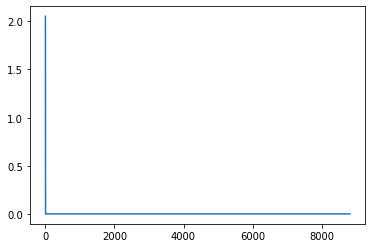

In [28]:
errors = [history[x]['Error'] for x in history.keys()]
plt.plot(errors)

In [29]:
errors

[2.0509225939241404,
 0.005178856461933713,
 0.0029905364799132387,
 0.00287167928050434,
 0.0028093772874004165,
 0.0027618568856859196,
 0.0027498169970803328,
 0.0027397112805214786,
 0.0027303828724529124,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397,
 0.0027281278192777397

In [123]:
del v, W, b